<a href="https://colab.research.google.com/github/gattuzzo0/advanced_ml/blob/main/A2b_DL_TC5033_AD2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch
<br>

### Students:
*   Andre Nicolai Gutiérrez Bautista
*   Fernando Guzmán Briones
*   Julio Osvaldo Hernández Bucio
*   Genaro Rodríguez Vázquez
<br>

---

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

#To avoid jupyter notebook crashing when ploting images
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#only if you have jupyterthemes

### Download Cifar10 dataset

In [2]:
# Aqui verificamos que nuestro environment reconozca correctamenrte nuestra GPU.
# Utilizaremos la GPU para poder hacer mas rapido el proceso de entrenamiento de la red neuronal
# ya que tomaremos ventaja del parallel computing permitido por la cantidad de tensores de nuestro hardware
# en este caso, utilizamos una GPU RTX 3000 en un equipo local
torch.cuda.is_available()

True

In [3]:
DATA_PATH = '/your_path'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000

# 256 para realizar el entrenamiento mas rapido, ya que la RAM disponible del equipo local
# en el que entrenamos el modelo lo permite
MINIBATCH_SIZE = 256 

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset
# Using sampler method is mutually exclusive to shuffle.
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
#Validation set
cifar10_val = datasets.CIFAR10(root='./data', train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
#Test set
cifar10_test = datasets.CIFAR10(root='./data', train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Print details of well known CIFAR10 dataset

In [4]:
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

### Using  GPUs

Corremos estas lineas de codigo para garantizar que el GPU es reconocido y sera utilizado para los entenamientos. La aceleracion por GPU nos dara resultados hasta un 80% mas rapido!

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Mostrar imágenes

Se muestra un ejemplo de una imagen

La imagen muestreada representa un: truck


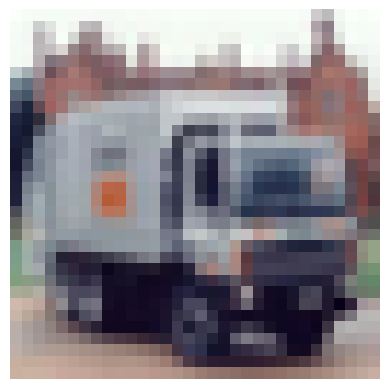

In [6]:
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


Para mostrar un grid de varias clases con varios ejemplos

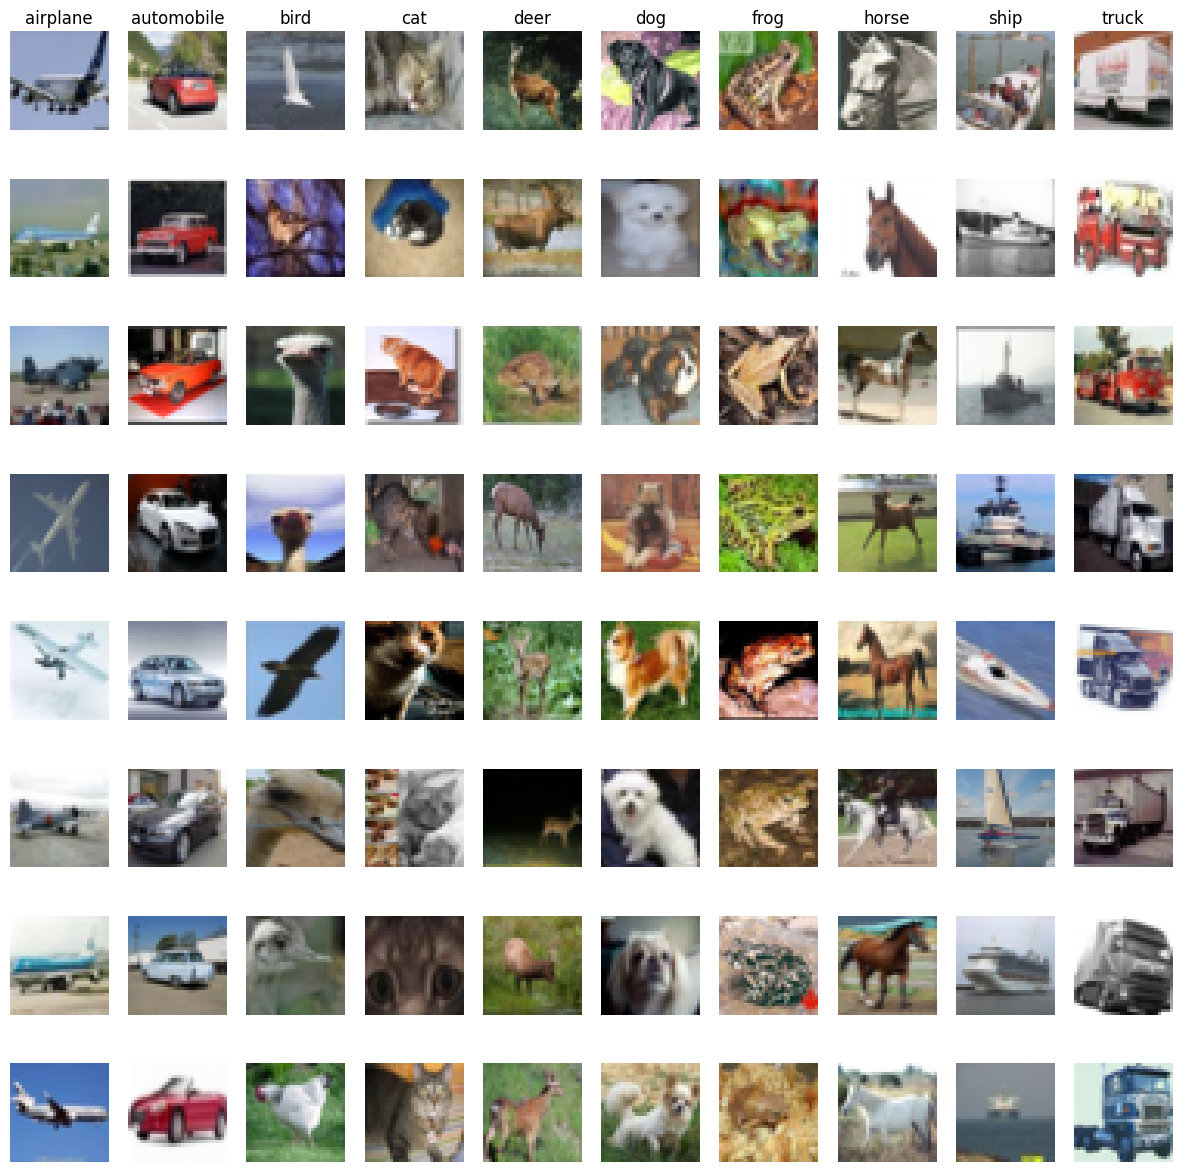

In [7]:
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()

### Calcular accuracy


total, correct y cost:
son variables que se utilizan para realizar un seguimiento de la cantidad total de ejemplos procesados, la cantidad de ejemplos clasificados correctamente y el costo total (pérdida) en el conjunto de datos, respectivamente.

Se inicia un bucle con torch.no_grad() para asegurarse de que no se realicen cálculos de gradiente durante la evaluación del modelo. Se establece el modelo en modo de evaluación con model.eval(). Esto es importante porque algunos módulos, como la capa de dropout, se comportan de manera diferente durante la evaluación.

El bucle itera a través de los datos en el cargador (loader). En cada iteración, se desempaquetan las imágenes y etiquetas del lote.

Las imágenes y etiquetas se mueven al dispositivo (por ejemplo, GPU) si se ha especificado mediante to(device=device, dtype=torch.float32).

Se realizan predicciones utilizando el modelo model en las imágenes de entrada xi.

La pérdida se calcula utilizando la función de entropía cruzada (cross-entropy) F.cross_entropy entre las puntuaciones predichas y las etiquetas reales.

Se determina cuántas de las predicciones son correctas al comparar las etiquetas predichas (pred) con las etiquetas reales (yi). La precisión se calcula como la proporción de predicciones correctas respecto al tamaño del lote.

Se actualizan las variables total, correct y cost con los valores acumulados durante cada iteración del bucle.

Una vez completado el bucle, se calcula la pérdida promedio dividiendo el costo total por el número de lotes en el conjunto de datos.

La precisión se calcula dividiendo el número total de predicciones correctas por el número total de ejemplos en el conjunto de datos.

La función devuelve la pérdida promedio y la precisión como una tupla (cost/len(data), float(correct)/total).

En resumen, esta función es útil para evaluar un modelo en un conjunto de datos y proporciona la pérdida promedio y la precisión del modelo en ese conjunto de datos.







In [8]:
# La función accuracy calcula la precisión y la pérdida de un modelo en un conjunto de datos 

def accuracy(model, loader):
  total = 0
  correct = 0
  cost = 0.

  with torch.no_grad():
      model.eval()
      for data in loader:
          # Desempaquetamos el dataset en np.arrays y etiquetas
          images, labels = data
          #outputs = net(images)
          xi = images.to(device=device, dtype = torch.float32)
          yi = labels.to(device=device, dtype = torch.long)
          
          #Hacemos las predicciones
          scores = model(xi)
          cost += (F.cross_entropy(scores, yi)).item()
          _, pred = scores.max(dim=1) #pred shape (mb_size )
          #_, predicted = torch.max(outputs.data, 1)

          # Append de resultados
          total += labels.size(0)
          #correct += (pred == labels).sum().item()
          correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
  # Return del valor total de costo y precision del dataset (loss % accuracy)
  return cost/len(data), float(correct)/total 

### Loop de entrenamiento

In [9]:
def train(model, optimiser, epochs=100):

  model = model.to(device=device)
  train_cost = 0.
  val_cost = 0.

  #Realizamos el entrenamiento cada epcoh, durante el numero definido de epochs en la definicion de hiperparametros.
  for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    train_correct_num  = 0.
    train_total = 0.
    train_cost_acum = 0

    #Los entrenamientos se corren sobre el dataset de entrenamiento (no test ni validacion)
    for i, data in enumerate(train_loader, 0):

      model.train()

      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data[0], data[1]

      xi = inputs.to(device=device, dtype=torch.float32)
      yi = labels.to(device=device, dtype=torch.long)

       # forward + backward + optimize

      scores = model(xi)
      cost = F.cross_entropy(input = scores, target= yi.squeeze())

      # zero the parameter gradients
      # debemos de reiniciar el gradiente en cada epoch, para no caer en error de memory leak
      optimiser.zero_grad()

      # funcion de costo
      cost.backward()
      optimiser.step()

      train_correct_num += (torch.argmax(scores, dim=1) == yi.squeeze()).sum()
      train_total += scores.size(0)

      train_cost_acum += cost.item()

    #Calculamos el costo y la precision despues de cada epoch entrenada
    # Debemos de hacer la evaluacion en el dataset de validacion (no el de entrenamiento)
    # El dataset de test se deberia de usar despues, para hacer la matriz de confusion.
    # Utilizar el mismo dataset durante el calculo de precision y perdida conllevaria a un problema 
    # de memory leak y no seria correcto.
    val_cost, val_acc = accuracy(model, val_loader)


    ### Train total -> tamano del dataset entrenado, en este caso 5000
    ### train_correct_num  -> Cantidad de items correctamente clasificados
    ### train_acc  -> Precision del modelo. Debe de tender a 1.
    ### train_cost  -> Funcion de costo (mayormente conocida como loss). Error acumulado. Debe de tender a 0
    train_acc = float(train_correct_num)/train_total
    train_cost = train_cost_acum/i

  # Vamos a monitorear la mejora cada 3 epochs
  # esto con el fin de lograr seleccionar el numero apropiado de epochs necesarios para lograr
  # el accuracy solicitado (evitar epcohs de sobra)
    if epoch%3 == 0:
      print(f'Epoch:{epoch}, train cost: {train_cost:.6f}, val cost: {val_cost:.6f},'
                      f' train acc: {train_acc:.4f}, val acc: {val_acc:4f},'
                      f' lr: {optimiser.param_groups[0]["lr"]:.6f}')                    

### Linear model

Se define un modelo lineal con una capa oculta y algunas capas auxiliares como la de aplanado, dropout y activación ReLU.

hidden = 64: Esto define el número de neuronas en la capa oculta del modelo. En este caso, hay 64 neuronas en la capa oculta.

input_size = 3 * 32 * 32: Esto calcula el tamaño de entrada para el modelo. Se asume que el modelo recibe imágenes en formato RGB de 32x32 píxeles, lo que da como resultado un tamaño de entrada de 3 (canales RGB) multiplicado por 32x32 (tamaño de la imagen).

linear_model: Aquí se define la arquitectura del modelo lineal utilizando la clase nn.Sequential, que permite definir una secuencia de capas en orden.

nn.Flatten(): Esta capa se utiliza para aplanar la entrada, convirtiendo una imagen 3D (3 canales x 32x32 píxeles) en un tensor 1D de 3072 elementos. Esto es necesario para que la entrada sea compatible con las capas lineales que siguen.

nn.Linear(in_features=input_size, out_features=hidden): Esta es la primera capa lineal que toma la entrada aplanada con input_size y produce una salida con hidden neuronas. Esta es la capa oculta del modelo.

nn.Dropout(): Esta capa aplica regularización de dropout. El valor de dropout no se ha especificado en este código, por lo que se utiliza el valor predeterminado. El dropout ayuda a prevenir el sobreajuste durante el entrenamiento al apagar aleatoriamente una fracción de las neuronas en cada iteración.

nn.ReLU(): Esta capa aplica la función de activación ReLU (Rectified Linear Unit) a la salida de la capa oculta. La función ReLU es comúnmente utilizada en redes neuronales para introducir no linealidad.

nn.Linear(in_features=hidden, out_features=10): La última capa lineal produce la salida final con 10 neuronas, que suele ser común en problemas de clasificación, donde se intenta asignar una de 10 posibles clases a la entrada.

In [10]:
# To do: Use PyTorch to create a linear model to have an initial baseline model

# Este modelo lineal solo tiene 1 capa oculta, fully connected
hidden = 64

# el input es una imagen de 32x32 pixeles, en 3 canales RGB
input_size = 3 * 32 * 32  
print(input_size)

# Se define la arquitectura del modelo lineal
linear_model = nn.Sequential(nn.Flatten(),
                       nn.Linear(in_features=input_size, out_features=hidden),
                       nn.Dropout(),
                       nn.ReLU(),                  
                       nn.Linear(in_features=hidden, out_features=10))


3072


El optimizador y las epochs se declaran aqui. Los parametros seleccionados aqui fueron los que arrojaron un mejor desempeno despues de varios experimientos de prueba y error. No hay una manera de saber a ciencia cierta el porque por ejemplo un LearningRate de 0.001 funciona mejor que uno de 0.01, simplemente el resultado es mejor con el primero.

In [11]:
epochs = 20
#optimiser = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
optimiser = torch.optim.Adam(linear_model.parameters(), lr=0.001)

Se entrena el modelo lineal (1 sola capa oculta)

Como se predijo desde un inicio, los resultados son muy pobres. Un accuracy de 50% aproximadamente es el alcanzado. Realmente solo se puede hacer un fine tunning ajustando el learning rate y no hay ninguna mejora con algun otro valor.

In [12]:
train(linear_model, optimiser, epochs)

Epoch:0, train cost: 1.928121, val cost: 16.464255, train acc: 0.3233, val acc: 0.426400, lr: 0.001000
Epoch:3, train cost: 1.702595, val cost: 15.438693, train acc: 0.3989, val acc: 0.466200, lr: 0.001000
Epoch:6, train cost: 1.659785, val cost: 15.046295, train acc: 0.4159, val acc: 0.474800, lr: 0.001000
Epoch:9, train cost: 1.623554, val cost: 14.837939, train acc: 0.4278, val acc: 0.484000, lr: 0.001000
Epoch:12, train cost: 1.604683, val cost: 14.695142, train acc: 0.4336, val acc: 0.494400, lr: 0.001000
Epoch:15, train cost: 1.590805, val cost: 14.616980, train acc: 0.4385, val acc: 0.489200, lr: 0.001000
Epoch:18, train cost: 1.571531, val cost: 14.612922, train acc: 0.4454, val acc: 0.488400, lr: 0.001000


### Sequential CNN

Constructor (__init__): En el constructor se definen todas las capas que componen la red y se inicializan sus parámetros.

self.custom_scale: Esta es una capa de convolución con 3 canales de entrada y 3 canales de salida. Utiliza un kernel de tamaño 7x7, un paso (stride) de 1 y sin relleno (padding). El peso de esta capa se inicializa como una matriz identidad 3x3, y el sesgo se establece en valores específicos.

self.conv1: Es la primera capa convolucional de la red, que toma 3 canales de entrada y produce 1024 canales de salida con un kernel de tamaño 5x5.

self.pool: Esta es una capa de max-pooling con un tamaño de ventana de 2x2 y un paso de 2x2.

self.conv2: La segunda capa convolucional, que toma los 1024 canales de salida de la capa anterior y reduce a 512 canales de salida con un kernel de tamaño 5x5.

self.fc1, self.fc2, self.fc3: Estas son capas completamente conectadas (fully connected) que toman los valores de las capas convolucionales y realizan operaciones lineales. La primera capa tiene 64 neuronas, la segunda tiene 64 neuronas y la tercera tiene 10 neuronas, que corresponderían a las clases de salida en un problema de clasificación.

---

Forward (forward): En el método forward, se define cómo se realiza el pase hacia adelante (forward pass) de la red. Aquí se describen las operaciones realizadas en cada capa:

self.custom_scale(x): Se aplica la capa personalizada de escala a la entrada x.

self.pool(F.relu(self.conv1(x))): La entrada pasa a través de la primera capa convolucional, se aplica una función de activación ReLU y luego se realiza max-pooling.

self.pool(F.relu(self.conv2(x))): Similar a la capa anterior, se aplica una segunda capa convolucional, se aplica ReLU y se realiza max-pooling.

torch.flatten(x, 1): Se aplana la salida para que pueda ser pasada a través de las capas completamente conectadas.

F.relu(self.fc1(x)): La salida aplanada se pasa a través de la primera capa completamente conectada con activación ReLU.

F.relu(self.fc2(x)): Luego, pasa a través de una segunda capa completamente conectada con activación ReLU.

self.fc3(x): Finalmente, se pasa a través de la última capa completamente conectada para obtener las salidas finales de la red.

En resumen, esta red es bastante profunda y realiza una serie de operaciones de convolución, activación y pooling, seguidas de capas completamente conectadas.



In [13]:
# To do: Use PyTorch to implement a CNN model, accuracy should be better than the linear model

# Esta arquitectura demostro obtener un nivel de precision bueno con un numero de epocas relativamente bajo
# El diseño de una CNN puede variar según la naturaleza del problema y el conjunto de datos. 
# Experimentar con diferentes arquitecturas y ajustes de hiperparámetros es esencial para obtener 
# el mejor rendimiento en una tarea de clasificación de imágenes específica.
class Sequential_CNN(nn.Module):
    def __init__(self):

        super().__init__()

        self.custom_scale = nn.Conv2d(3, 3, kernel_size=7, stride=1, padding=0)
        self.custom_scale.weight.data = torch.eye(3).view(3, 3, 1, 1)
        self.custom_scale.bias.data = torch.Tensor([0.491, 0.482, 0.447])

        self.conv1 = nn.Conv2d(3, 1024, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(1024, 512, 5)
        self.fc1 = nn.Linear(512 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.custom_scale(x)  # Apply custom scaling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

sequential_model = Sequential_CNN()    

 Se crea un optimizador SGD con una tasa de aprendizaje de 0.01 que se utilizará para ajustar los parámetros del modelo sequential_model durante el entrenamiento. El SGD es un algoritmo comúnmente utilizado en el entrenamiento de redes neuronales para minimizar la función de pérdida y mejorar el rendimiento del modelo.

In [21]:
epochs = 40
#optimiser = torch.optim.Adam(net.parameters(), lr=0.0001)
#optimiser = torch.optim.SGD(sequential_model.parameters(), lr=0.01)
optimiser = torch.optim.SGD(sequential_model.parameters(), lr=0.01, momentum=0.9)

In [22]:
train(sequential_model, optimiser, epochs)  

Epoch:0, train cost: 1.210552, val cost: 13.011031, train acc: 0.6066, val acc: 0.547800, lr: 0.010000
Epoch:3, train cost: 0.832802, val cost: 8.901779, train acc: 0.7116, val acc: 0.693000, lr: 0.010000
Epoch:6, train cost: 0.627741, val cost: 9.301430, train acc: 0.7820, val acc: 0.702800, lr: 0.010000
Epoch:9, train cost: 0.484967, val cost: 9.125248, train acc: 0.8302, val acc: 0.719200, lr: 0.010000
Epoch:12, train cost: 0.374731, val cost: 10.290114, train acc: 0.8670, val acc: 0.720600, lr: 0.010000
Epoch:15, train cost: 0.284031, val cost: 11.662376, train acc: 0.9000, val acc: 0.717200, lr: 0.010000
Epoch:18, train cost: 0.209788, val cost: 13.569699, train acc: 0.9253, val acc: 0.707400, lr: 0.010000
Epoch:21, train cost: 0.161317, val cost: 15.531576, train acc: 0.9421, val acc: 0.697400, lr: 0.010000
Epoch:24, train cost: 0.139730, val cost: 16.758739, train acc: 0.9513, val acc: 0.709000, lr: 0.010000
Epoch:27, train cost: 0.120447, val cost: 17.333475, train acc: 0.9585,

# Conclusion

Utilizando un batch size de 256, 40 epochs (como maximo), un learning rate de 1e-2 y un optimizador SVG, se logro obtener una precision de 72% en 12 epochs en el dataset de validacion. 
Despues de la epoch 15, tiende a presentar sobreentrenamiento.


Es importante mencionar que debemos de observar que la precision debe de tender al 100%, pero deben de tender a converger tambien las curvas de entrenamiento y validacion. De nada sirve obtener un accuracy muy alto en entrenamiento cuando el de validacion es muy bajo, ya que eso seria un claro indicador de sobreentrenamiento (Overfitting).

Las redes neuronales profundas (Deep Neural Networks, DNN) y las redes neuronales lineales (o perceptrones multicapa) tienen diferentes características y ventajas, y la elección entre ellas depende del tipo de problema que estés abordando y de tus recursos disponibles. Aquí tienes algunas ventajas de las redes neuronales profundas en comparación con las redes neuronales lineales:

# Ventajas de las Redes Neuronales Profundas (DNN):

Mayor Capacidad de Representación: Las redes neuronales profundas tienen la capacidad de aprender representaciones jerárquicas de los datos. Esto significa que pueden capturar características y patrones complejos en los datos, lo que las hace adecuadas para tareas más complejas.

Mejor Rendimiento en Datos Complejos: Las DNN son especialmente efectivas en conjuntos de datos complejos, como imágenes, texto, audio y video, donde las características relevantes están distribuidas en múltiples capas de abstracción.

Habilidad para Abordar Tareas de Visión por Computadora: En problemas de visión por computadora, como reconocimiento de objetos, segmentación de imágenes y detección de objetos, las redes neuronales profundas, como las CNN (Convolutional Neural Networks), han demostrado un rendimiento sobresaliente.

Problemas de Procesamiento de Lenguaje Natural (NLP): Para tareas de procesamiento de lenguaje natural, como traducción automática, resumen de texto y análisis de sentimientos, las DNN, incluidas las RNN (Redes Neuronales Recurrentes) y las LSTM (Long Short-Term Memory), han tenido un gran éxito.

Transferencia de Aprendizaje: Las DNN permiten la transferencia de aprendizaje, lo que significa que puedes entrenar un modelo en un conjunto de datos grande y utilizarlo como punto de partida para tareas relacionadas, lo que ahorra tiempo y recursos.

# Ventajas de las Redes Neuronales Lineales:

Simplicidad: Las redes neuronales lineales son más simples y fáciles de entender. Son adecuadas para problemas más simples donde los datos se pueden modelar de manera efectiva con una capa oculta o menos.

Menos Requisitos de Datos: Para entrenar una red neuronal lineal, a menudo se requieren menos datos en comparación con una red profunda. Esto es útil en situaciones donde tienes un conjunto de datos pequeño.

Menor Costo Computacional: Entrenar una red neuronal lineal generalmente requiere menos recursos computacionales en comparación con una red profunda. Esto es beneficioso si tienes limitaciones de hardware.

En resumen, las redes neuronales profundas son poderosas y se utilizan en una amplia variedad de aplicaciones, especialmente en tareas de visión por computadora y procesamiento de lenguaje natural. Sin embargo, las redes neuronales lineales aún tienen su lugar en problemas más simples o en situaciones en las que los recursos son limitados. La elección entre una DNN y una red neuronal lineal depende de la complejidad del problema y de los recursos disponibles.




